# This notebook contains:
* Hovmöller diagrams of surface energy budget variables

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask

In [2]:
# open netcdf files created in BA_variable-to-netcdf notebook
# mean over radar domain
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
barra_towns_rad = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc-energy-budget_towns.nc", engine="h5netcdf",chunks="auto")
barra_cairns_rad = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc-energy-budget_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis_rad = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc-energy-budget_willis.nc", engine="h5netcdf",chunks="auto")

In [3]:
def regime(barra_site,deg1,deg2,variable_ds,ne=None,all_winds=None):
    winds = barra_site.wind_dir.compute()
    if ne==True:
        winds_dir = winds[(winds>=deg1)&(winds<=deg2)]
    else:
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
    if all_winds==True:
        winds_dir = winds
    else:
        pass
    # now that the regime composite times have been defined, calculate the diurnal mean of variable in question 
    
    regime = variable_ds.sel(time=winds_dir.time.values,method='nearest')
    mean_values = regime.groupby(regime.time.dt.hour).mean(dim='time')
    # shift from utc to aest
    aest = np.roll(mean_values,shift=10,axis=0)
    # for plotting, double array to show 48 hours
    double = np.concatenate([aest,aest]) 
    return double

In [5]:
# from above function calc regime mean for variable: regime(barra_site,deg1,deg2,variable_ds,ne=None,all_winds=None)
sfc_ne_dwSW = regime(barra_cairns,0,90,barra_cairns_rad.sfc_dw_SW,ne=True,all_winds=False)
sfc_se_dwSW = regime(barra_cairns,90,180,barra_cairns_rad.sfc_dw_SW,ne=False,all_winds=False)
sfc_sw_dwSW = regime(barra_cairns,180,270,barra_cairns_rad.sfc_dw_SW,ne=False,all_winds=False)
sfc_nw_dwSW = regime(barra_cairns,270,360,barra_cairns_rad.sfc_dw_SW,ne=False,all_winds=False)

sfc_ne_uwSW = regime(barra_cairns,0,90,barra_cairns_rad.sfc_uw_SW,ne=True,all_winds=False)
sfc_se_uwSW = regime(barra_cairns,90,180,barra_cairns_rad.sfc_uw_SW,ne=False,all_winds=False)
sfc_sw_uwSW = regime(barra_cairns,180,270,barra_cairns_rad.sfc_uw_SW,ne=False,all_winds=False)
sfc_nw_uwSW = regime(barra_cairns,270,360,barra_cairns_rad.sfc_uw_SW,ne=False,all_winds=False)

sfc_ne = sfc_ne_dwSW - sfc_ne_uwSW
sfc_se = sfc_se_dwSW - sfc_se_uwSW
sfc_sw = sfc_sw_dwSW - sfc_sw_uwSW
sfc_nw = sfc_nw_dwSW - sfc_nw_uwSW

In [17]:
sfc_ne.max()

822.198911516854

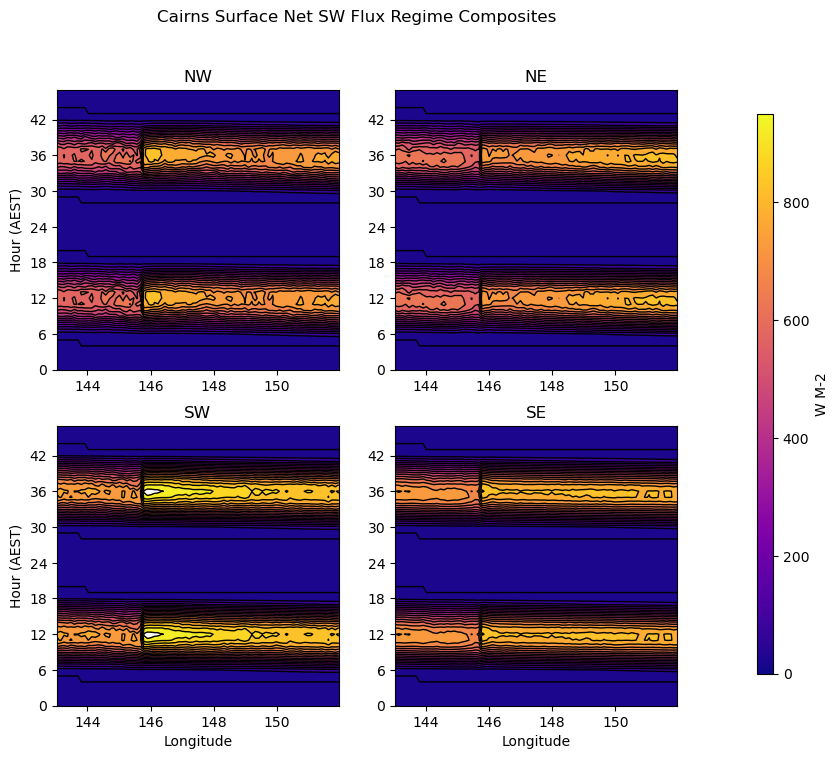

In [19]:
def plot_barra_variables(barra_variable,level,cmap,scm,ne,se,sw,nw,cbar_label,title):
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    fig.patch.set_facecolor('white')
    levels = level
    cf_ne = ax[0,1].contourf(barra_variable.lon,np.arange(0,48,1),ne,levels=levels,cmap=cmap)
    cf_se = ax[1,1].contourf(barra_variable.lon,np.arange(0,48,1),se,levels=levels,cmap=cmap)
    cf_sw = ax[1,0].contourf(barra_variable.lon,np.arange(0,48,1),sw,levels=levels,cmap=cmap)
    cf_nw = ax[0,0].contourf(barra_variable.lon,np.arange(0,48,1),nw,levels=levels,cmap=cmap)
    ax[0,1].contour(barra_variable.lon,np.arange(0,48,1),ne,levels=levels,colors="black",linewidths=1)
    ax[1,1].contour(barra_variable.lon,np.arange(0,48,1),se,levels=levels,colors="black",linewidths=1)
    ax[1,0].contour(barra_variable.lon,np.arange(0,48,1),sw,levels=levels,colors="black",linewidths=1)
    ax[0,0].contour(barra_variable.lon,np.arange(0,48,1),nw,levels=levels,colors="black",linewidths=1)
    # for colorbar plotting
    cax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    # # Create a colorbar using the ScalarMappable from one of the subplots
    sm = plt.cm.ScalarMappable(cmap=scm)
    sm.set_array(levels)  # You need to set an array for the ScalarMappable
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(cbar_label,fontsize=10)
    yticks = np.arange(0,48,6)
    ax[0,1].set_yticks(yticks)
    ax[1,1].set_yticks(yticks)
    ax[1,0].set_yticks(yticks)
    ax[0,0].set_yticks(yticks)
    
    ax[0,0].set_ylabel('Hour (AEST)')
    ax[1,0].set_ylabel('Hour (AEST)')
    ax[1,0].set_xlabel('Longitude')
    ax[1,1].set_xlabel('Longitude')
    
    ax[0,1].set_title("NE")
    ax[1,1].set_title("SE")
    ax[1,0].set_title("SW")
    ax[0,0].set_title("NW")
    fig.suptitle(title+' Regime Composites')
    return
plot_barra_variables(barra_cairns_rad,np.arange(0,1000,50),"plasma",plt.cm.plasma,sfc_ne,sfc_se,sfc_sw,sfc_nw,'W M-2','Cairns Surface Net SW Flux')

Text(0.5, 1.0, 'Surface Net SW Radiation')

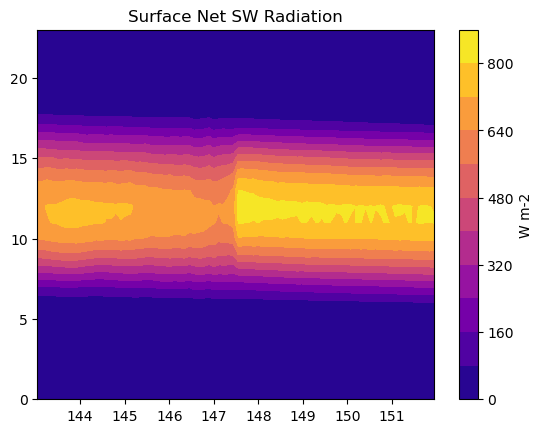

In [22]:
variable = barra_towns_rad.sfc_uw_SW.groupby(barra_towns_rad.time.dt.hour).mean(dim="time")
variable1 = barra_towns_rad.sfc_dw_SW.groupby(barra_towns_rad.time.dt.hour).mean(dim="time")
net = variable1-variable
aest = np.roll(net,shift=10,axis=0)
plt.contourf(barra_towns_rad.lon,np.arange(0,24,1),aest,levels=10,cmap='plasma')
cb=plt.colorbar()
cb.set_label('W m-2')
plt.title("Surface Net SW Radiation")

In [24]:
barra_towns_rad

<xarray.Dataset> Size: 219MB
Dimensions:             (time: 30288, lon: 82)
Coordinates:
  * time                (time) datetime64[ns] 242kB 2012-01-01T00:30:00 ... 2...
    lat                 float64 8B ...
  * lon                 (lon) float64 656B 143.0 143.1 143.3 ... 151.8 151.9
    level_height        float64 8B ...
    model_level_number  int32 4B ...
    sigma               float64 8B ...
Data variables:
    sfc_dw_LW           (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_dw_clr_LW       (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_uw_LW           (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_uw_clr_LW       (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_dw_SW           (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_dw_clr_SW       (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_uw_SW           (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_uw_clr_SW       (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_direct_dw_SW    (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_up_sensible     (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
    sfc_up_latent       (time, lon) float64 20MB dask.array<chunksize=(30288, 82), meta=np.ndarray>
Attributes:
    note:     JFMA mean surface energy budget variables for townsville longit...